# Road Accident Survival Dataset

## 1. Understanding the Problem

The problem is to understand which factors explain if a person can survive from a road accident.

## 2. Data Understanding

Structure of the data:

* **Features**:
  * **Age**: age
  * **Gender**: Female / Male
  * **Speed_of_Impact**: Speed of Impact
  * **Helmet_Used**: Helmet Used?
  * **Seatbelt_Used**: Seatbelt Used?
* **Target variable**:
  * **Survived**: 1 (survived) / 0 (no survived)

Link: https://www.kaggle.com/datasets/himelsarder/road-accident-survival-dataset

## 3. Data exploration

### 3.1. Review the state of the data - PySpark

In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

In [2]:
# Identify data location
PATH_DATA = os.path.join(os.getenv("PATH_DATA_PROJECTS"), "Tabular", "Road Accident Survival")

In [3]:
# Create spark session
spark = SparkSession.builder.appName("RoadAccidentSurvivalSession").getOrCreate()

In [4]:
# Define schema
data_schema = StructType([
    StructField("Age", IntegerType(), True),
    StructField("Gender", StringType(), True),
    StructField("Speed_of_Impact", IntegerType(), True),
    StructField("Helmet_Used", StringType(), True),
    StructField("Seatbelt_Used", StringType(), True),
    StructField("Survived", IntegerType(), True)
])

# Read CSV file
df = spark.read.option("delimiter", ",") \
                .option("header", True) \
                .option("inferSchema", False) \
                .schema(data_schema) \
                .csv(os.path.join(PATH_DATA, "accident.csv"))

df.show(5)

+---+------+---------------+-----------+-------------+--------+
|Age|Gender|Speed_of_Impact|Helmet_Used|Seatbelt_Used|Survived|
+---+------+---------------+-----------+-------------+--------+
| 56|Female|             27|         No|           No|       1|
| 69|Female|             46|         No|          Yes|       1|
| 46|  Male|             46|        Yes|          Yes|       0|
| 32|  Male|            117|         No|          Yes|       0|
| 60|Female|             40|        Yes|          Yes|       0|
+---+------+---------------+-----------+-------------+--------+
only showing top 5 rows



In [5]:
# Identify missing values
missing_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+---+------+---------------+-----------+-------------+--------+
|Age|Gender|Speed_of_Impact|Helmet_Used|Seatbelt_Used|Survived|
+---+------+---------------+-----------+-------------+--------+
|  0|     1|              3|          0|            0|       0|
+---+------+---------------+-----------+-------------+--------+



### 3.2. Data cleaning - PySpark

In [6]:
# Remove missing values for Gender
df = df.na.drop(subset = ["Gender"])

In [7]:
# Fill missing values using media for Speed_of_Impact
median_speed = df.approxQuantile("Speed_of_Impact", [0.5], 0.05)[0]
df = df.na.fill(({"Speed_of_Impact": median_speed}))

In [8]:
# Save results as CSV file
df_pandas = df.toPandas()
df_pandas.to_csv("accidents.csv", index = False)

### 3.3. Create script

In [39]:
%%writefile src/spark_data_processing.py
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Get input path
PATH_DATA = ""

# Create spark session
spark = SparkSession.builder.appName("RoadAccidentSurvivalSession").getOrCreate()

################################## START READ INPUT DATA ##################################
print("Start read input data")
data_schema = StructType([
    StructField("Age", IntegerType(), True),
    StructField("Gender", StringType(), True),
    StructField("Speed_of_Impact", IntegerType(), True),
    StructField("Helmet_Used", StringType(), True),
    StructField("Seatbelt_Used", StringType(), True),
    StructField("Survived", IntegerType(), True)
])

df = spark.read.option("delimiter", ",") \
                .option("header", True) \
                .option("inferSchema", False) \
                .schema(data_schema) \
                .csv(os.path.join(PATH_DATA, "accident.csv"))

print("Finish read input data")
################################## FINISH READ INPUT DATA ##################################

################################## START DATA CLEANING ##################################
print("Start data cleaning")

# Identify missing values
missing_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

# Remove missing values for Gender column
df = df.na.drop(subset = ["Gender"])

# Fill missing values for Speed_of_Impact column
median_speed = df.approxQuantile("Speed_of_Impact", [0.5], 0.05)[0]
df = df.na.fill(({"Speed_of_Impact": median_speed}))

print("Finish data cleaning")
################################## FINISH DATA CLEANING ##################################

################################## START SAVE DATA RESULTS ##################################
print("Start save data results")
#df.write.mode("overwrite").saveAsTable("accidents")
df_pandas = df.toPandas()
df_pandas.to_csv(os.path.join(PATH_DATA, "accident_cleaned.csv"), index = False)
print("Finish save data results")
################################## FINISH SAVE DATA RESULTS ##################################

Overwriting src/spark_data_processing.py


### 3.3. Exploratory Data Analysis (EDA)

Explore the data distribucion.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_csv("accidents.csv")
print("df shape:", df.shape)
df.head()

df shape: (199, 6)


,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27,No,No,1
1,69,Female,46,No,Yes,1
2,46,Male,46,Yes,Yes,0
3,32,Male,117,No,Yes,0
4,60,Female,40,Yes,Yes,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              199 non-null    int64 
 1   Gender           199 non-null    object
 2   Speed_of_Impact  199 non-null    int64 
 3   Helmet_Used      199 non-null    object
 4   Seatbelt_Used    199 non-null    object
 5   Survived         199 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 9.5+ KB


#### 3.3.1. Target variable

In [5]:
target_variable = "Survived"

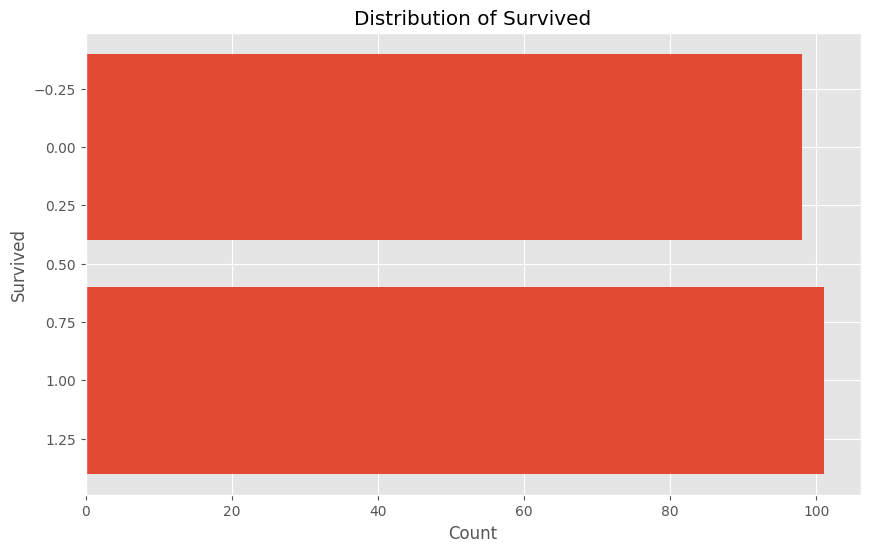

In [6]:
df_count = df["Survived"].value_counts()

plt.figure(figsize = (10, 6))
plt.barh(df_count.index, df_count.values)
plt.xlabel("Count")
plt.ylabel("Survived")
plt.title("Distribution of Survived")
plt.gca().invert_yaxis()
plt.show()

#### 3.3.2. Categorical

##### Explore distribution

In [7]:
categorical_features = ["Gender", "Helmet_Used", "Seatbelt_Used"]

In [8]:
for c in categorical_features:
    print("\nFeature:", c)
    print(df[c].unique())


Feature: Gender
['Female' 'Male']

Feature: Helmet_Used
['No' 'Yes']

Feature: Seatbelt_Used
['No' 'Yes']


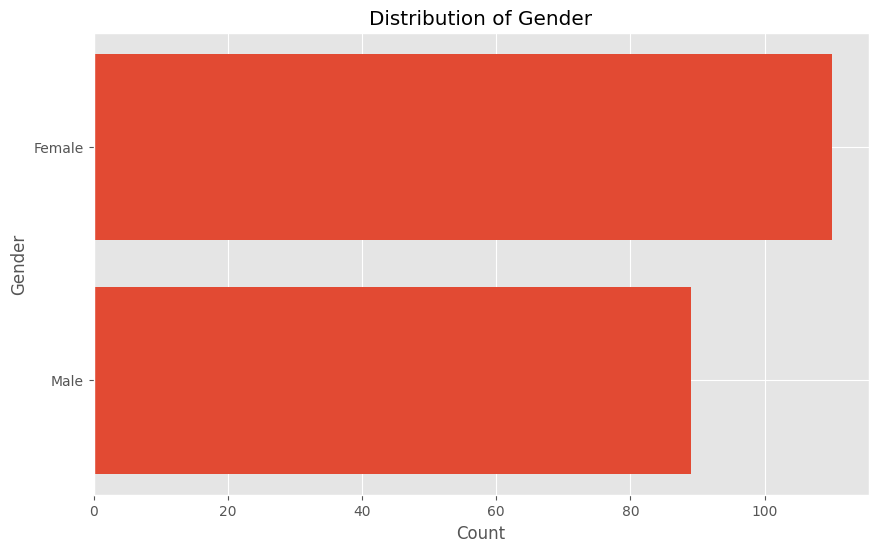

In [9]:
df_count = df["Gender"].value_counts()

plt.figure(figsize = (10, 6))
plt.barh(df_count.index, df_count.values)
plt.xlabel("Count")
plt.ylabel("Gender")
plt.title("Distribution of Gender")
plt.gca().invert_yaxis()
plt.show()

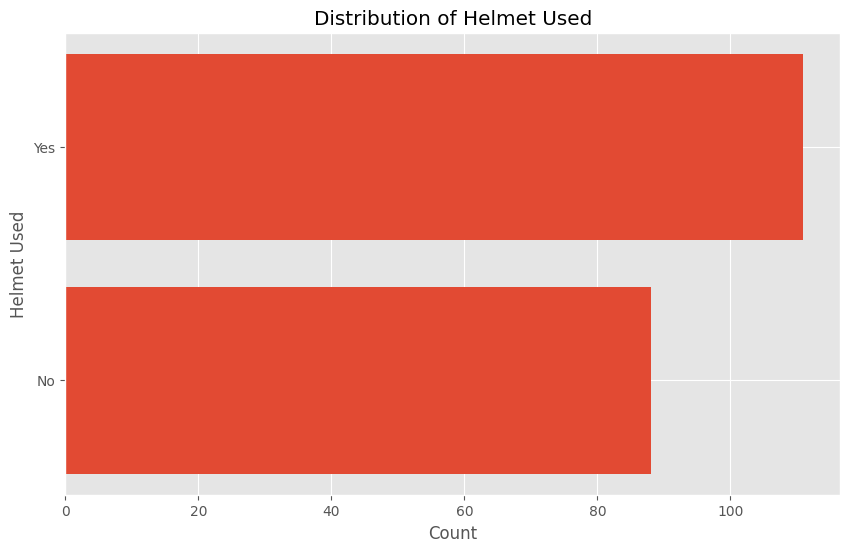

In [10]:
df_count = df["Helmet_Used"].value_counts()

plt.figure(figsize = (10, 6))
plt.barh(df_count.index, df_count.values)
plt.xlabel("Count")
plt.ylabel("Helmet Used")
plt.title("Distribution of Helmet Used")
plt.gca().invert_yaxis()
plt.show()

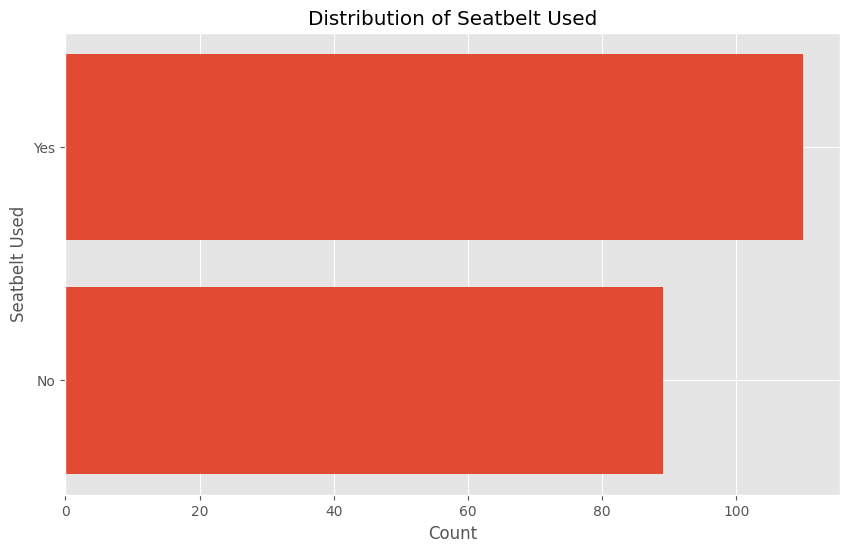

In [11]:
df_count = df["Seatbelt_Used"].value_counts()

plt.figure(figsize = (10, 6))
plt.barh(df_count.index, df_count.values)
plt.xlabel("Count")
plt.ylabel("Seatbelt Used")
plt.title("Distribution of Seatbelt Used")
plt.gca().invert_yaxis()
plt.show()

#### 3.3.3. Numeric

In [17]:
numeric_features = ["Age", "Speed_of_Impact"]

In [18]:
df[numeric_features].describe()

,Age,Speed_of_Impact
count,199.000000,199.000000
mean,43.311558,70.427136
std,14.892999,29.972605
min,18.000000,20.000000
25%,31.000000,43.000000
50%,43.000000,71.000000
75%,56.000000,95.000000
max,69.000000,119.000000


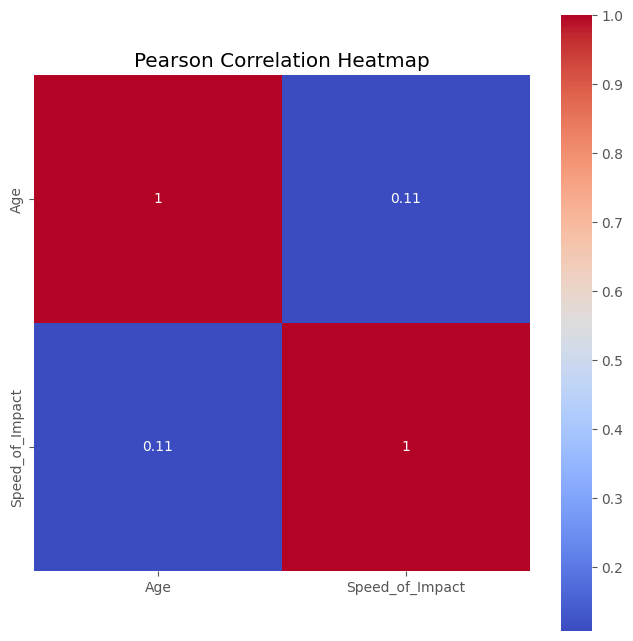

In [19]:
correlation_matrix = df[numeric_features].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", square = True)
plt.title("Pearson Correlation Heatmap")
plt.show()

## 4. Modeling

In [20]:
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split

In [ ]:
h2o.init()

### 4.1. Data preparation

In [22]:
df_train, df_val = train_test_split(df, test_size = 0.2, random_state = 42)
print("df_train shape:", df_train.shape)
print("df_val shape:", df_val.shape)

df_train shape: (159, 6)
df_val shape: (40, 6)


In [23]:
df_train_h2o = h2o.H2OFrame(df_train)
df_train_h2o[target_variable] = df_train_h2o[target_variable].asfactor()

for c in categorical_features:
    df_train_h2o[c] = df_train_h2o[c].asfactor()

df_train_h2o.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:159
Cols:6

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
type,int,enum,int,enum,enum,enum
mins,18.0,,20.0,,,
mean,43.61635220125787,,71.16352201257861,,,
maxs,69.0,,119.0,,,
sigma,14.967390182921914,,30.164711173408325,,,
zeros,0,,0,,,
missing,0,0,0,0,0,0
0,61.0,Female,29.0,Yes,Yes,1
1,69.0,Female,52.0,Yes,No,1
2,38.0,Female,25.0,Yes,Yes,0


In [24]:
df_val_h2o = h2o.H2OFrame(df_val)
df_val_h2o[target_variable] = df_val_h2o[target_variable].asfactor()

for c in categorical_features:
    df_val_h2o[c] = df_val_h2o[c].asfactor()

df_val_h2o.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:40
Cols:6

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
type,int,enum,int,enum,enum,enum
mins,18.0,,23.0,,,
mean,42.099999999999994,,67.50000000000003,,,
maxs,69.0,,119.0,,,
sigma,14.717510937829406,,29.386897481526415,,,
zeros,0,,0,,,
missing,0,0,0,0,0,0
0,32.0,Male,34.0,Yes,Yes,1
1,41.0,Female,70.0,No,No,0
2,34.0,Male,87.0,Yes,No,1


### 4.2. Training

In [25]:
x = df_train_h2o.columns
y = target_variable

x.remove(y)

aml = H2OAutoML(max_runtime_secs = 600,
                #exclude_algos =["DeepLearning"],
                seed = 1,
                stopping_metric = "auc",
                sort_metric = "logloss",
                balance_classes = True,
                project_name = "Project_1"
)

aml.train(x = x, y = y, training_frame = df_train_h2o)

AutoML progress: |
19:59:20.673: AutoML: XGBoost is not available; skipping it.


19:59:21.573: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 159.0.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),1/71
# GBM base models (used / total),0/35
# GLM base models (used / total),0/1
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),1/33
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


### 4.4. Validation

Identify the best models

In [ ]:
lb = aml.leaderboard
lb.head(rows = 10)

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_6_AutoML_1_20250225_195920,0.68376,0.600887,0.564069,0.453358,0.495226,0.245248
StackedEnsemble_BestOfFamily_3_AutoML_1_20250225_195920,0.691893,0.57618,0.565573,0.459455,0.498862,0.248864
StackedEnsemble_BestOfFamily_6_AutoML_1_20250225_195920,0.695312,0.445518,0.481748,0.5,0.50108,0.251081
StackedEnsemble_AllModels_3_AutoML_1_20250225_195920,0.696082,0.591384,0.542417,0.397846,0.500279,0.25028
StackedEnsemble_AllModels_1_AutoML_1_20250225_195920,0.698568,0.402043,0.440873,0.493506,0.502696,0.252703
GLM_1_AutoML_1_20250225_195920,0.698922,0.417485,0.451222,0.5,0.502872,0.252881
GBM_grid_1_AutoML_1_20250225_195920_model_3,0.699643,0.538328,0.51755,0.453358,0.502875,0.252883
StackedEnsemble_AllModels_4_AutoML_1_20250225_195920,0.70186,0.546088,0.533706,0.465553,0.503469,0.253481
GBM_grid_1_AutoML_1_20250225_195920_model_98,0.702455,0.487171,0.484303,0.487013,0.504517,0.254538
GBM_grid_1_AutoML_1_20250225_195920_model_100,0.704417,0.524153,0.504743,0.466741,0.505112,0.255138


Try out the best model

In [34]:
best_model = h2o.get_model("GLM_1_AutoML_1_20250225_195920")
best_model.model_performance(df_val_h2o)

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2501573390842848
RMSE: 0.5001573143364844
LogLoss: 0.6934616161735556
AUC: 0.6265664160401002
AUCPR: 0.5268125769097559
Gini: 0.25313283208020043
Null degrees of freedom: 39
Residual degrees of freedom: 31
Null deviance: 55.617177063722195
Residual deviance: 55.476929293884446
AIC: 73.47692929388444

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5124564197278675
       0    1    Error    Rate
-----  ---  ---  -------  -----------
0      9    12   0.5714   (12.0/21.0)
1      2    17   0.1053   (2.0/19.0)
Total  11   29   0.35     (14.0/40.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.512456     0.708333  28
max f2                       0.511018     0.825688  32
max f0point5                 0.513498     0.629921  26
max accuracy                 0.513498     0.65      26
max precision                0.514664     0.611111  17
max recall                   0.507747     1         39
max specificity              0.521862     0.952381  0
max absolute_mcc             0.512456     0.361583  28
max min_per_class_accuracy   0.514457     0.619048  19
max mean_per_class_accuracy  0.512456     0.661654  28
max tns                      0.521862     20        0
max fns                      0.521862     19        0
max fps                      0.50794      21        38
max tps                      0.507747     19        39
max tnr                      0.521862     0.952381  0
max fnr                      0.521862     1         0
max fpr                      0.50794      1         38
max tpr                      0.507747     1         39

Gains/Lift Table: Avg response rate: 47.50 %, avg score: 51.45 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.025                       0.521268           0         0                  0                0.521862  0                           0.521862            0               0                          -100      -100               -0.047619
2        0.025                       0.520673           0         0                  0                0         0                           0.521862            0               0                          -100      -100               -0.047619
3        0.05                        0.520309           0         0                  0                0.520338  0                           0.5211              0               0                          -100      -100               -0.0952381
4        0.05                        0.520241           0         0                  0                0         0                           0.5211              0               0                          -100      -100               -0.0952381
5        0.05                        0.520174           0         0                  0                0         0                           0.5211              0               0                          -100      -100               -0.0952381
6        0.1                         0.518792           2.10526   1.05263            1                0.519936  0.5                         0.520518            0.105263        0.105263                   110.526   5.26316            0.0100251
7        0.15                        0.518503           1.05263   1.05263            0.5              0.518658  0.5                         0.519898            0.0526316       0.157895     

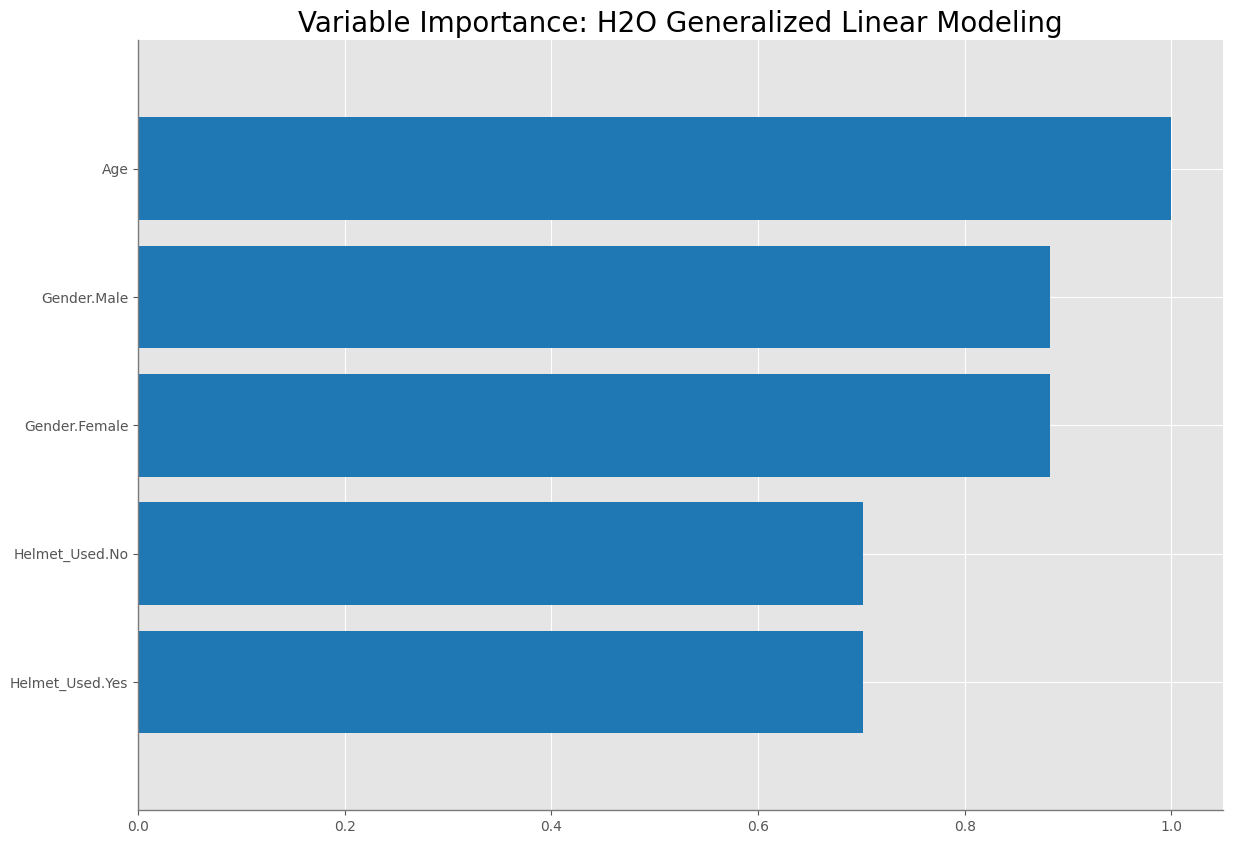

<Figure size 640x480 with 0 Axes>

In [35]:
# plot the graph for variable importance
best_model.varimp_plot(num_of_features = 5)

Save the best model

In [ ]:
model_path = h2o.save_model(model = best_model, path = "", force = True)
print(f"Model saved to: {model_path}")

### 4.5. Create script

In [46]:
%%writefile src/h2o_training.py
import h2o
import os
import pandas as pd
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split

# Get input path
PATH_DATA = ""
target_variable = "Survived"
categorical_features = ["Gender", "Helmet_Used", "Seatbelt_Used"]

print("Start h2o init")
h2o.init()
print("Finish h2o init")

print("Start spliting data")
df = pd.read_csv(os.path.join(PATH_DATA, "accident_cleaned.csv"))

df_train, df_val = train_test_split(df, test_size = 0.2, random_state = 42)
print("df_train shape:", df_train.shape)
print("df_val shape:", df_val.shape)
print("Finish spliting data")

print("Start preparing training data")
df_train_h2o = h2o.H2OFrame(df_train)
df_train_h2o[target_variable] = df_train_h2o[target_variable].asfactor()

for c in categorical_features:
    df_train_h2o[c] = df_train_h2o[c].asfactor()

df_train_h2o.describe()
print("Finish preparing training data")

print("Start preparing validation data")
df_val_h2o = h2o.H2OFrame(df_val)
df_val_h2o[target_variable] = df_val_h2o[target_variable].asfactor()

for c in categorical_features:
    df_val_h2o[c] = df_val_h2o[c].asfactor()

df_val_h2o.describe()
print("Finish preparing validation data")

print("Start training")
x = df_train_h2o.columns
y = target_variable

x.remove(y)

aml = H2OAutoML(max_runtime_secs = 600,
                #exclude_algos =["DeepLearning"],
                seed = 1,
                stopping_metric = "auc",
                sort_metric = "logloss",
                balance_classes = True,
                project_name = "Project_2"
)

aml.train(x = x, y = y, training_frame = df_train_h2o)
print("Finish training")

print("Start validation")
best_model = aml.leader
best_model.model_performance(df_val_h2o)

model_path = h2o.save_model(model = best_model, path = PATH_DATA, force = True)
print(f"Model saved to: {model_path}")
print("Finish validation")

Overwriting src/h2o_training.py
